# Basic registration with Twocan defaults

This notebook demonstrates a basic image registration workflow using the `Twocan` library. We will register an example same-slide co-stained IF and IMC image using the default utilities:
1. Preprocessors `IFprocessor` and `IMCprocessor`
1. `RegEstimator` to get the transformation matrix
1. `registation_trial` and `iou_corr_single_objective` which are designed for IF/IMC registration

Custom functions can be provided in place of these defaults to register pairs of images of different technologies or experimental set ups (eg. serial sections) 

We will set the IF as the "fixed" or target image, and IMC as the "moving" or soruce image. 


In [2]:
import numpy as np
from twocan import RegEstimator, iou_corr_single_objective, get_aligned_coordinates
from twocan.utils import pick_best_registration 
from twocan.plotting import plot_registration, get_merge, AsinhNorm
import matplotlib.pyplot as plt
from spatialdata import read_zarr
from spatialdata.transformations import Affine
import spatialdata_plot
from skimage import transform
import optuna


/home/harrigan/.conda/envs/twocan/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/home/harrigan/.conda/envs/twocan/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Load data

In [3]:
sdata = read_zarr('data/cell-line-0028-bd18455.zarr')

Both the IF and IMC image are saved into this zarr, with their channel names. The IMC image has a transformation matrix in the 'aligned' coordinate system, and we will show how this matrix was found using Twocan. Take a peek:  

In [4]:
sdata.images

{'IF': <xarray.DataArray 'image' (c: 3, y: 512, x: 512)> Size: 2MB
dask.array<from-zarr, shape=(3, 512, 512), dtype=uint16, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U4 48B 'DAPI' 'GFP' 'RFP'
  * y        (y) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * x        (x) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes:
    transform:  {'global': Identity }, 'IMC': <xarray.DataArray 'image' (c: 24, y: 944, x: 953)> Size: 86MB
dask.array<from-zarr, shape=(24, 944, 953), dtype=float32, chunksize=(24, 944, 953), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U12 1kB '-' 'pHH3_S28' '-' '-' ... 'PCNA' 'DNA1' 'DNA2' '-'
  * y        (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 940.5 941.5 942.5 943.5
  * x        (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 949.5 950.5 951.5 952.5
Attributes:
    transform:  {'global': Identity , 'aligned': Sequence \n    Identity \n  ...}

Twocan provides a custom normalization function `AsinhNorm` to display  IMC signal.  

The two images are of the same set of cells, but need to be registered in order to line up their signal!

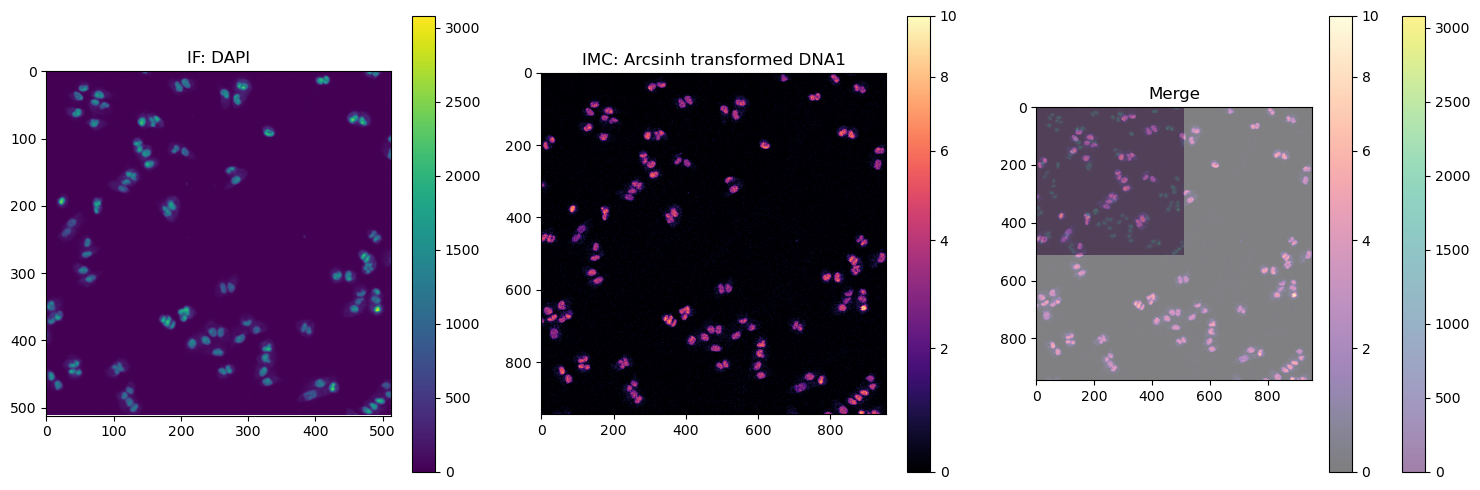

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sdata.pl.render_images('IF', channel='DAPI').pl.show(coordinate_systems=["global"], title="IF: DAPI", ax=ax1)
sdata.pl.render_images('IMC', channel='DNA1', cmap='magma', norm=AsinhNorm(vmax=10)).pl.show(coordinate_systems=["global"],title="IMC: Arcsinh transformed DNA1", ax=ax2)
sdata.pl.render_images('IF', channel='DAPI', alpha = 0.5).pl.show(coordinate_systems=["global"], ax=ax3)
sdata.pl.render_images('IMC', channel='DNA1', cmap='magma', norm=AsinhNorm(vmax=10), alpha = 0.5).pl.show(coordinate_systems=["global"], title="Merge", ax=ax3)
plt.tight_layout()

## Run optimization to find the best registration parameters

We will register using nuclear channels: DAPI and DNA1/DNA2 respectively. All channels with matching names to the list will be summed along the channel axis to create the registration image. That is: DAPI will be registered to the DNA1+DNA2 signal. 

In [6]:
registration_channels = ['DAPI', 'DNA1', 'DNA2']

We'll now run an `optuna` study where each trial suggests preprocessing parameters, and attempts a registration. Note that most of the time, no registration is found, and the value of the trial is 0.

The resolution of the IF image (1.714um/px) is different from the IMC (1um/px), we'll start with a rough rescaling. 

In [7]:
from spatialdata.models import Image2DModel

sdata['IF_rescaled'] = Image2DModel.parse(data=np.array([transform.rescale(x, 1.714) for x in sdata['IF']]), c_coords = sdata['IF'].c)


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


In [12]:
study = optuna.create_study(direction='maximize', study_name="example_1", sampler=optuna.samplers.TPESampler(seed=435))

[I 2025-05-30 18:29:33,804] A new study created in memory with name: example_1


In [13]:
study.optimize(lambda trial: iou_corr_single_objective(trial, sdata, registration_channels, moving_image = 'IMC', static_image = 'IF_rescaled'), n_trials=50)

[I 2025-05-30 18:29:35,341] Trial 0 finished with value: 0.0 and parameters: {'IF_binarization_threshold': 0.933211670587485, 'IF_gaussian_sigma': 3.970471856959729, 'IMC_arcsinh_normalize': True, 'IMC_arcsinh_cofactor': 82.24156916480698, 'IMC_winsorization_lower_limit': 0.09696780729863419, 'IMC_winsorization_upper_limit': 0.1783479041671231, 'IMC_binarization_threshold': 0.8096163889460634, 'IMC_gaussian_sigma': 0.08971807860817027, 'binarize_images': True, 'registration_max_features': 100000, 'registration_percentile': 0.9, 'moving_image': 'IMC', 'static_image': 'IF_rescaled'}. Best is trial 0 with value: 0.0.
[I 2025-05-30 18:29:35,570] Trial 1 finished with value: 0.0 and parameters: {'IF_binarization_threshold': 0.8268084153290103, 'IF_gaussian_sigma': 4.500237321883176, 'IMC_arcsinh_normalize': False, 'IMC_arcsinh_cofactor': 49.28179415212745, 'IMC_winsorization_lower_limit': 0.12881211103925472, 'IMC_winsorization_upper_limit': 0.02522637646225481, 'IMC_binarization_threshold'

## Pick best trial

We can checkout the parameters selected for the best trial
Twocan suggests the best trial based on the balanced score, this is not necessarily the same trial as that which maximizes the optimization objectives: this can be extracted with the optuna method `study.best_trial`

In [14]:
optuna_best_trial = study.best_trial
print(optuna_best_trial)

FrozenTrial(number=44, state=TrialState.COMPLETE, values=[0.6526415943925467], datetime_start=datetime.datetime(2025, 5, 30, 18, 31, 50, 529365), datetime_complete=datetime.datetime(2025, 5, 30, 18, 31, 55, 319088), params={'IF_binarization_threshold': 0.14055633731267614, 'IF_gaussian_sigma': 1.2547537115861847, 'IMC_arcsinh_normalize': False, 'IMC_arcsinh_cofactor': 45.46181262714963, 'IMC_winsorization_lower_limit': 0.16133138741487346, 'IMC_winsorization_upper_limit': 0.049350827068444396, 'IMC_binarization_threshold': 0.6210991405573469, 'IMC_gaussian_sigma': 1.1854010829079855, 'binarize_images': True, 'registration_max_features': 100000, 'registration_percentile': 0.9, 'moving_image': 'IMC', 'static_image': 'IF_rescaled'}, user_attrs={'registration_matrix': array([[ 9.95031054e-01,  1.25336820e-03, -4.52149509e+01],
       [-1.25336820e-03,  9.95031054e-01, -3.89747629e+01]]), 'source_sum': 39953, 'target_sum': 38512, 'logical_and': 33675, 'logical_or': 44790, 'logical_xor': 111

In [15]:
twocan_best_trial = pick_best_registration(study.trials_dataframe())
print(twocan_best_trial)

number                                                                                 44
value                                                                            0.652642
datetime_start                                                 2025-05-30 18:31:50.529365
datetime_complete                                              2025-05-30 18:31:55.319088
duration                                                           0 days 00:00:04.789723
params_IF_binarization_threshold                                                 0.140556
params_IF_gaussian_sigma                                                         1.254754
params_IMC_arcsinh_cofactor                                                     45.461813
params_IMC_arcsinh_normalize                                                        False
params_IMC_binarization_threshold                                                0.621099
params_IMC_gaussian_sigma                                                        1.185401
params_IMC

We can also check out the registration matrix

In [16]:
twocan_best_trial['user_attrs_registration_matrix'].round(2)

array([[  1.  ,   0.  , -45.21],
       [ -0.  ,   1.  , -38.97]])

## Visualize result

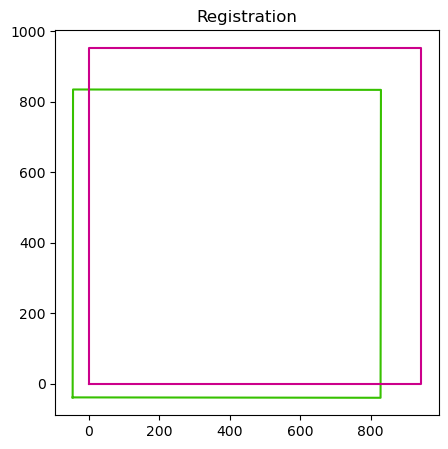

In [17]:
plt.figure(figsize=(5, 5))
plot_registration(sdata['IF_rescaled'], sdata['IMC'], twocan_best_trial['user_attrs_registration_matrix'])
plt.title('Registration')
plt.show()

# Register!

Assuming we've found a suitable registration matrix using Twocan, we can apply this to transform our moving image to align with the static image.

We'll show two ways to do this:
1. SpatialData
2. skimage

## Recommendations

Use SpatialData when:
* You're working with spatial omics data (spatial transcriptomics, proteomics, etc.)
* Data integrity and preservation of original resolutions is critical
* You plan to integrate with single-cell analysis workflows
* You can tolerate some API instability for the benefits of a purpose-built solution

Use skimage when:
* You need direct image manipulation and standard computer vision workflows
Visualization flexibility is a priority
* You're comfortable with resampling trade-offs
* You need to export standard image formats for use in other tools
* You're working primarily with imaging data rather than omics data

You can of course mix and match when you use each approach: SpatialData stores images such that they can always be turned into numpy arrays, so we recommend keeping raw data in zarrs, and transforming on the fly whenever a numpy array or tiff is needed. 

For more info, see https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/transformations_advanced.html


## SpatialData 

### Pros:
* Integrated with AnnData ecosystem: Seamlessly works with single-cell and spatial omics analysis pipelines, making it ideal for spatial transcriptomics, proteomics, and other omics data types
* Maintains original image resolutions: Stores transformation matrices separately rather than resampling images, preserving the native resolution and pixel spacing of each modality
* Preserves data integrity: By applying transformations only during analysis rather than to the raw data, it avoids introducing interpolation artifacts or information loss
* Supports multiple coordinate systems: Can handle complex transformations and maintain relationships between different spatial coordinate systems
* Designed for spatial omics workflows: Built specifically with spatial biology applications in mind, supporting common data types and analysis patterns

### Cons:
* Relatively new library with evolving API: As of May 2025, under active development, which means breaking changes are possible and documentation may be incomplete
* Learning curve: Helpful to have some familiarity with the SpatialData/AnnData ecosystem


### Transform

First we'll use the transformation matrix found by Twocan to make a SpatialData affine transform, then we'll write that to the coordinate system in the sdata called 'aligned' 

In [18]:

M = twocan_best_trial['user_attrs_registration_matrix']
affine = Affine(np.vstack([M, np.array([0,0,1])]), input_axes=("x", "y"), output_axes=("x", "y"))
get_aligned_coordinates(sdata['IMC'], sdata['IF_rescaled'], affine)
    

In [19]:
sdata

SpatialData object, with associated Zarr store: /lila/home/harrigan/repair-quant/twocan_repo/notebooks/data/cell-line-0028-bd18455.zarr
└── Images
      ├── 'IF': DataArray[cyx] (3, 512, 512)
      ├── 'IF_rescaled': DataArray[cyx] (3, 878, 878)
      └── 'IMC': DataArray[cyx] (24, 944, 953)
with coordinate systems:
    ▸ 'aligned', with elements:
        IMC (Images)
    ▸ 'global', with elements:
        IF (Images), IF_rescaled (Images), IMC (Images)
with the following elements not in the Zarr store:
    ▸ IF_rescaled (Images)

### Visualize the transformation

We'll use the `render_images` function to visualize the transformation.



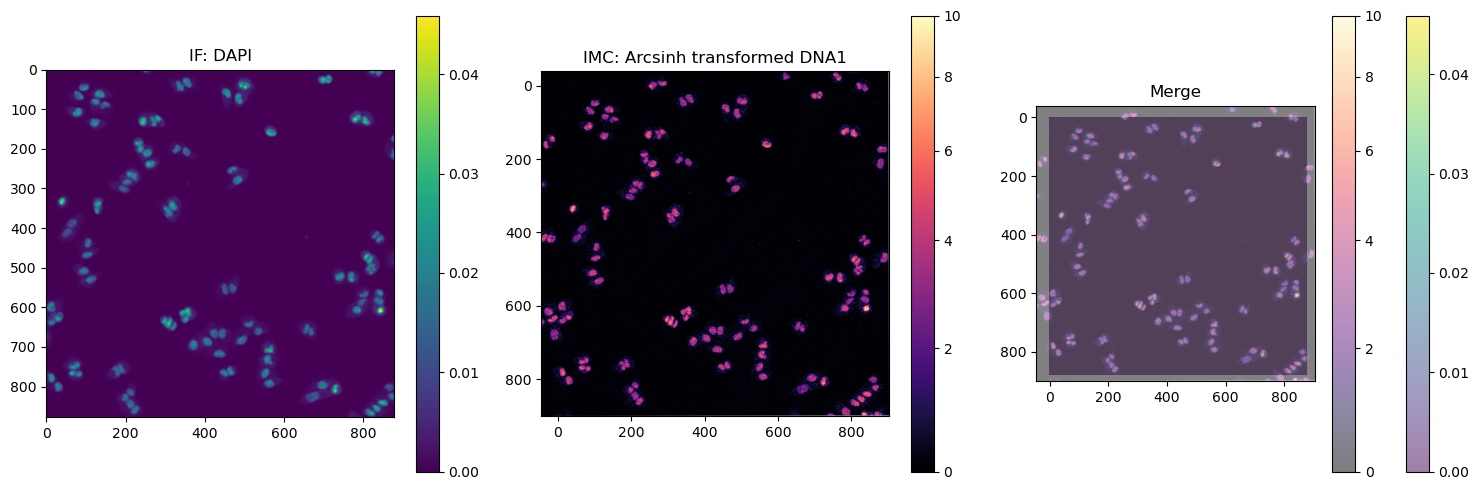

In [20]:


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sdata.pl.render_images('IF_rescaled', channel='DAPI').pl.show(coordinate_systems=["global"], title="IF: DAPI", ax=ax1)
sdata.pl.render_images('IMC', channel='DNA1', cmap='magma', norm=AsinhNorm(vmax=10)).pl.show(coordinate_systems=["aligned"], title="IMC: Arcsinh transformed DNA1", ax=ax2)
sdata.pl.render_images('IF_rescaled', channel='DAPI', alpha = 0.5).pl.show(coordinate_systems=["global"], ax=ax3)
sdata.pl.render_images('IMC', channel='DNA1', cmap='magma', norm=AsinhNorm(vmax=10), alpha = 0.5).pl.show(coordinate_systems=["aligned"], title="Merge", ax=ax3)
plt.tight_layout()


## Skimage/numpy 
### Pros:

* Direct manipulation of image arrays: Provides immediate access to pixel data as numpy arrays, allowing for straightforward image processing operations
* Flexible for visualization and plotting: Use matplotlib for custom plots

### Cons:
* Requires resampling: Forces at least one modality to be transformed to match the resolution of another, which is often necessary but not always desirable
* Potential information loss: Resampling introduces interpolation artifacts and may lose fine spatial details, especially when downsampling high-resolution images
* Poor handling of irregular regions: NumPy arrays are rectangular, so handling ragged edges, circular regions, or other non-rectangular areas requires masking and can be cumbersome
* Metadata loss: Standard image formats like TIFF may not preserve all the spatial metadata, coordinate system information, or transformation history
* Memory intensive: Storing multiple resampled high-resolution images can consume significant memory


### Apply the transformation

We will "stack" the IMC image on top of IF to create one big numpy array with 3 + 24 channels

In [21]:
reg = RegEstimator()
reg.M_ = twocan_best_trial['user_attrs_registration_matrix']

stack = reg.transform(sdata['IMC'], sdata['IF_rescaled'])
stack.shape

(27, 878, 878)

We have to store channel names separately

In [22]:
stack_channels = np.concatenate([sdata['IMC'].c.values, sdata['IF_rescaled'].c.values])

Make a cartoon of the registration

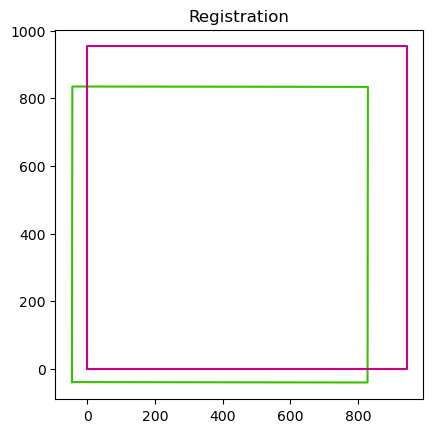

In [23]:
plot_registration(sdata['IF_rescaled'], sdata['IMC'], twocan_best_trial['user_attrs_registration_matrix'])
plt.title('Registration')
plt.show()


Show the transformed data

In [24]:
stack[stack_channels == 'DNA1'][0].shape

(878, 878)

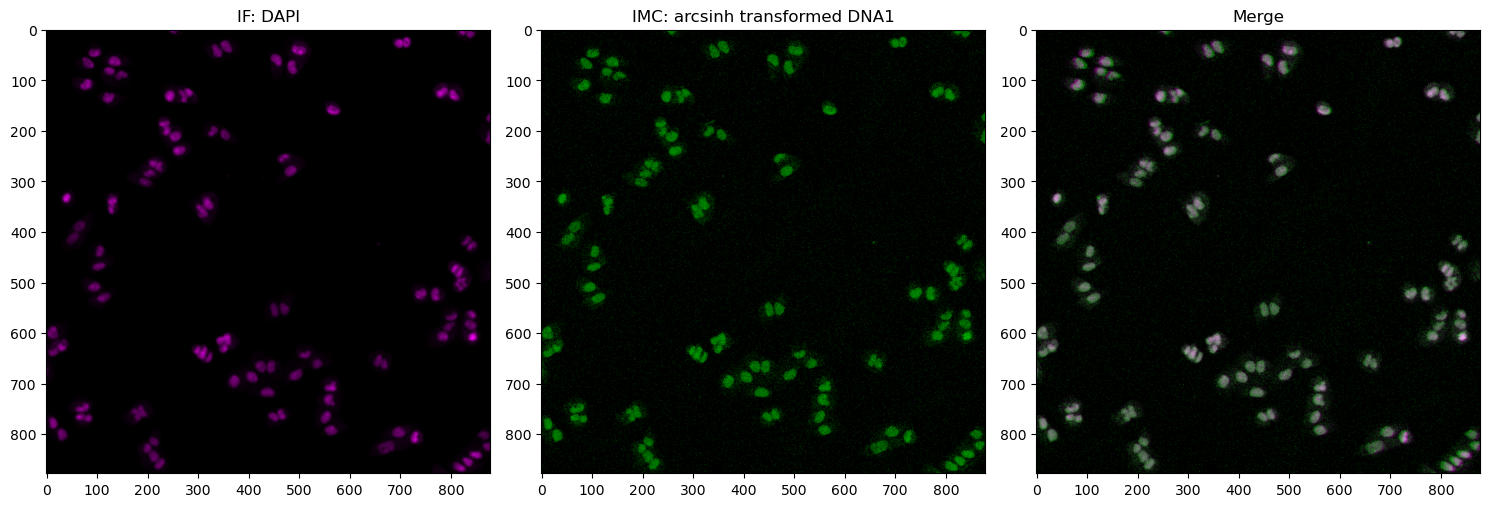

In [25]:
green, magenta, merge = get_merge(np.arcsinh(stack[stack_channels == 'DNA1'][0]), stack[stack_channels == 'DAPI'][0])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(magenta) 
axes[0].set_title('IF: DAPI')
axes[1].imshow(green)
axes[1].set_title('IMC: arcsinh transformed DNA1')
axes[2].imshow(merge)
axes[2].set_title('Merge')
plt.tight_layout()
plt.show()



